In [1]:
import sys, os, glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
# from libs.activations import lrelu
import math
import numpy as np
import random as rnd

In [3]:
# %%
# load training image
train_images = np.load('train_images.npy')
print(train_images.shape)
# mean_img = np.mean(train_images, axis=0)
# print('mean_img.shape =', mean_img.shape)
# plt.figure()
# plt.imshow(mean_img[:, :, 0], cmap='gray')

# load training cmd
train_cmds = np.load("train_cmds.npy")
print(train_cmds.shape)
train_steps = train_cmds[:, 0]
train_angles = train_cmds[:, 1]
print(train_steps.shape, train_angles.shape)

# load training image2
train_images2 = np.load('train_images2.npy')
print(train_images2.shape)
# mean_img2 = np.mean(train_images2, axis=0)
# print('mean_img2.shape =', mean_img2.shape)
# plt.figure()
# plt.imshow(mean_img2[:, :, 0], cmap='gray')

# load training cmd2
train_cmds2 = np.load("train_cmds2.npy")
print(train_cmds2.shape)
train_steps2 = train_cmds2[:, 0]
train_angles2 = train_cmds2[:, 1]
print(train_steps2.shape, train_angles2.shape)

(40000, 40, 320, 1)
(39999, 3)
(39999,) (39999,)
(40000, 40, 320, 1)
(39999, 3)
(39999,) (39999,)


In [34]:
def add_encoder_layer(x, n_filters, filter_size, strides, deta=200.0):
    # %%
    # input to the network
#     x = tf.placeholder(tf.float32, input_shape, name='x')

    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the encoder
    n_input = x.get_shape().as_list()[3]
    n_output = n_filters
    W = tf.Variable(
            tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                -1.0 / math.sqrt(filter_size[0]*filter_size[1]*n_input),
                1.0 / math.sqrt(filter_size[0]*filter_size[1]*n_input)))
    b = tf.Variable(tf.zeros([n_output]))
    z = tf.nn.relu(tf.add(tf.nn.conv2d(x, W, strides=[1, strides[0], strides[1], 1], padding='VALID'), b))
    print('The encoding layer z has shape', z.get_shape())

    # %%
    # Build the decoder using the same weights
    b2 = tf.Variable(tf.zeros([n_input]))
    y = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(z, W, input_shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2))
    print('The output layer y has shape', y.get_shape())

    # %%
    # the reconstruction through the network
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x))
        
    l2_regularizer = tf.contrib.layers.l2_regularizer(scale=deta, scope=None)
#   weights = tf.trainable_variables()
    l2_cost = tf.contrib.layers.apply_regularization(l2_regularizer, [W])
        
    cost_t = cost + l2_cost

    # %%
    # define the optimizer
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_t)
        
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z, 'y': y, 'W': W, 'b': b, 'b2': b2, 'cost': cost, 'l2_cost': l2_cost, 'cost_t': cost_t, 'optimizer':optimizer}
        
    return ae

In [13]:
saved_model = 'modelxxx3'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 2
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The output layer y has shape (40, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
0 :1: 0 :cost = 1604.2 l2_cost = 543.995 cost_t = 2148.19
0 :1: 1000 :cost = 1266.58 l2_cost = 512.459 cost_t = 1779.04
0 :1: 2000 :cost = 1689.22 l2_cost = 528.638 cost_t = 2217.86
0 :1: 3000 :cost = 1345.42 l2_cost = 562.952 cost_t = 1908.37
0 :1: 4000 :cost = 1497.98 l2_cost = 547.136 cost_t = 2045.12
0 :1: 5000 :cost = 1523.24 l2_cost = 556.357 cost_t = 2079.6
0 :1: 6000 :cost = 1356.1 l2_cost = 535.516 cost_t = 1891.62
0 :1: 7000 :cost = 1268.84 l2_cost = 519.46 cost_t = 1788.3
0 :1: 8000 :cost = 1712.15 l2_cost = 577.839 cost_t = 2289.99
0 :1: 9000 :cost = 1544.44 l2_cost = 557.751 cost_t = 2102.19
0 :1: 10000 :cost = 1324.17 l2_cost = 535.671 cost_t = 1859.84
0 :1: 11000 :cost = 1521.35 l2_cost = 565.329 cost_t = 2086.68
0 :1: 12000 :cost = 1203.15 l2_cost = 525.887 cost_t = 1729.04
0 :

1 :2: 9000 :cost = 1246.97 l2_cost = 578.067 cost_t = 1825.03
1 :2: 10000 :cost = 1454.14 l2_cost = 573.017 cost_t = 2027.16
1 :2: 11000 :cost = 1310.58 l2_cost = 540.943 cost_t = 1851.52
1 :2: 12000 :cost = 1275.16 l2_cost = 527.085 cost_t = 1802.25
1 :2: 13000 :cost = 1307.02 l2_cost = 563.415 cost_t = 1870.43
1 :2: 14000 :cost = 1200.08 l2_cost = 569.253 cost_t = 1769.33
1 :2: 15000 :cost = 1146.3 l2_cost = 513.262 cost_t = 1659.56
1 :2: 16000 :cost = 1394.12 l2_cost = 545.652 cost_t = 1939.77
1 :2: 17000 :cost = 1413.83 l2_cost = 534.811 cost_t = 1948.64
1 :2: 18000 :cost = 1459.04 l2_cost = 557.097 cost_t = 2016.14
1 :2: 19000 :cost = 1350.51 l2_cost = 552.093 cost_t = 1902.6
1 :2: 20000 :cost = 1395.0 l2_cost = 571.236 cost_t = 1966.24
1 :2: 21000 :cost = 1182.97 l2_cost = 578.262 cost_t = 1761.23
1 :2: 22000 :cost = 1233.24 l2_cost = 558.655 cost_t = 1791.9
1 :2: 23000 :cost = 1298.13 l2_cost = 526.692 cost_t = 1824.82
1 :2: 24000 :cost = 1502.13 l2_cost = 589.729 cost_t = 2091.

The input layer x has shape (4, 40, 320, 1)
The encoding layer z has shape (4, 9, 63, 10)
The output layer y has shape (4, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
[ 0.  0.  0.] [-10. -10. -10.]
[ 0.  0.  2.] [-10. -10.   0.]
(8, 40, 320, 1) (8, 40, 320, 1)


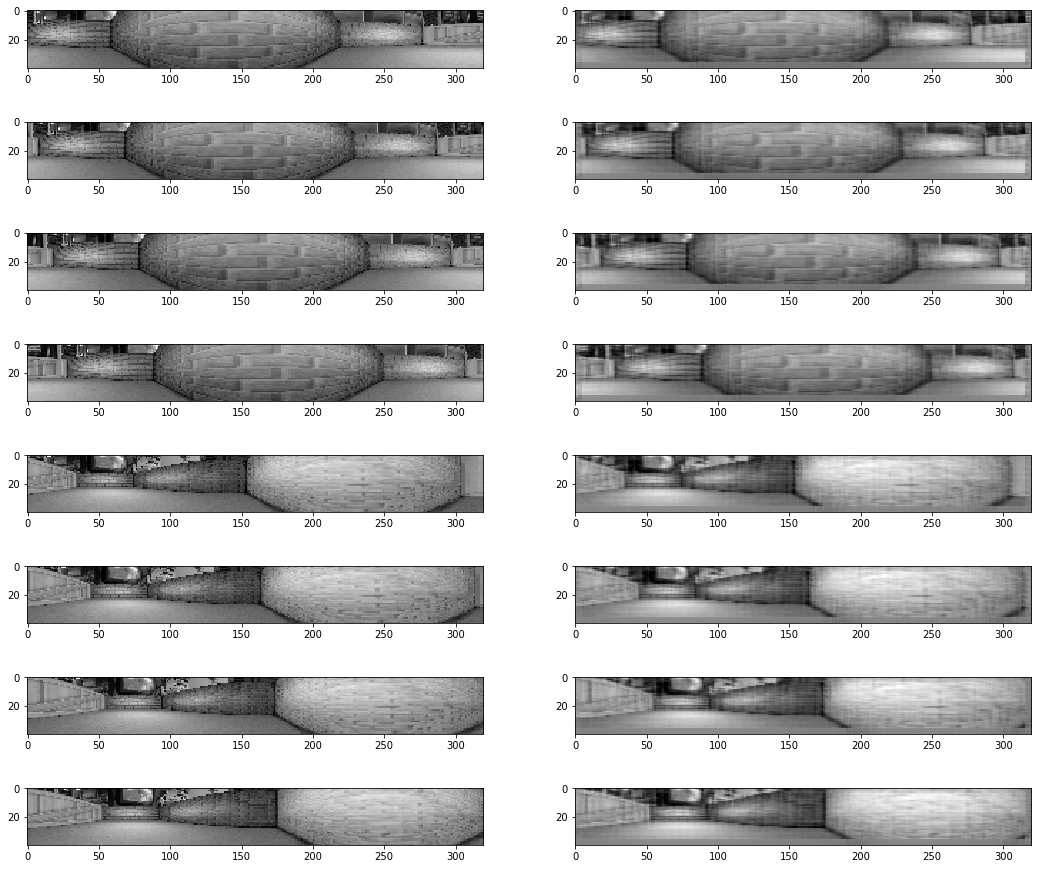

In [14]:
saved_model = 'modelxxx3'
example_num = 4

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
#     test_xs_norm = np.array([img - mean_img for img in test_xs])
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print(steps_test, angles_test)
    recon = sess.run(ae['y'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
#     test_xs_norm = np.array([img - mean_img2 for img in test_xs2])
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print(steps_test, angles_test)
    recon2 = sess.run(ae['y'], feed_dict={x: test_xs_norm})

    test_xs = np.concatenate((test_xs, test_xs2), axis=0)
    recon = np.concatenate((recon, recon2), axis=0)
    print(test_xs.shape, recon.shape)
    fig, axs = plt.subplots(example_num*2, 2, figsize=(18, 4*example_num))
    for example_i in range(example_num*2):
        axs[example_i][0].imshow(test_xs[example_i, :, :, 0], cmap='gray')
        if example_i < example_num/2:
#             axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img[:, :, 0], cmap='gray')
            axs[example_i][1].imshow(recon[example_i, :, :, 0], cmap='gray')
        else:
#             axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img2[:, :, 0], cmap='gray')
            axs[example_i][1].imshow(recon[example_i, :, :, 0], cmap='gray')
    plt.show()

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The output layer y has shape (40, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
step commands are [ 0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  2.  2.  2.  0.  0.  0.  0.  2.
  2.  2.  2.  2.  0.  0.  0.  0.  0.  2.  2.  2.  0.  0.  0.  2.  0.  2.
  0.  0.  0.]
angle commands are [ 10.  10.  10.  10.   0.  10.  10.  10.  10.  10.   0.   0.   0. -10. -10.
 -10. -10.   0.   0.   0.   0.   0.  10.  10.  10.  10.  10.   0.   0.   0.
  10.  10.  10.   0.  10.   0.  10.  10.  10.]
step commands are [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.  2.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  2.  0.
  0.  0.  0.]
angle commands are [-10. -10. -10. -10. -10. -10. -10. -10.   0. -10. -10.   0.   0.   0.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.   0.   0.   0. -10. -10. -10. -10.]
z1.shape = (

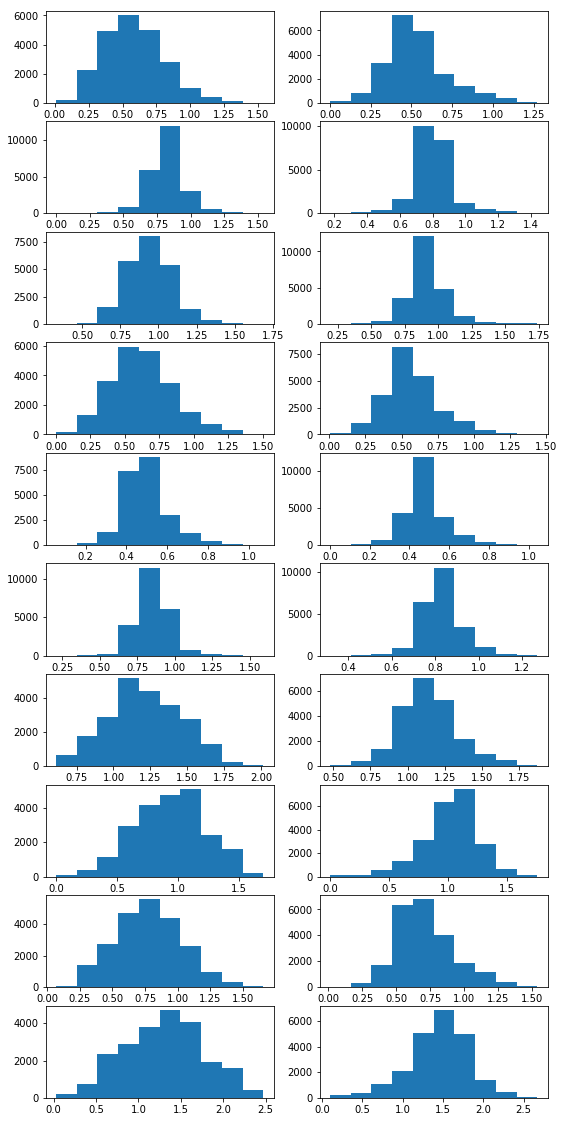

In [15]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx3'
example_num = 40

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z1 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z2 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    print('z1.shape =', z1.shape)
    print('z2.shape =', z2.shape)

shape = z1.shape.as_list()
tmp1 = np.reshape(z1, (shape[0]*shape[1]*shape[2], shape[3]))
# plt.hist(tmp1[:, 0])
tmp2 = np.reshape(z2, (shape[0]*shape[1]*shape[2], shape[3]))
fig, axes = plt.subplots(10, 2, figsize=(9, 20))
for idx in range(10):
    axes[idx, 0].hist(tmp1[:, idx])
    axes[idx, 1].hist(tmp2[:, idx])

### Get the pretained weights

The input layer x has shape (2, 40, 320, 1)
The encoding layer z has shape (2, 9, 63, 10)
The output layer y has shape (2, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
w1.shape =  (8, 10, 1, 10) b1.shape =  (10,)
w1_val.shape = (8, 10, 1, 10)
max 0.188276 min -0.258297
max 0.195832 min -0.284833
max 0.269719 min -0.266409
max 0.165591 min -0.321095
max 0.17104 min -0.34666
max 0.295261 min -0.16514
max 0.186171 min -0.201123
max 0.25863 min -0.185888
max 0.18916 min -0.279841
max 0.261533 min -0.0690637


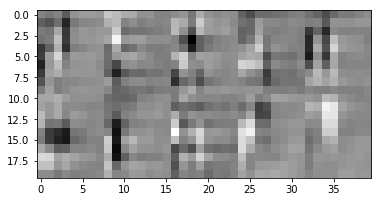

In [16]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx3'
example_num = 2

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    w1, b1 = sess.run([ae['W'], ae['b']])
    print('w1.shape = ', w1.shape, 'b1.shape = ', b1.shape)
    np.save('model/w1.npy', w1)
    np.save('model/b1.npy', b1)
    
w1_val = np.load('model/w1.npy')
print('w1_val.shape =', w1_val.shape)
h = w1_val.shape[0]
w = w1_val.shape[1]
wi_image = np.zeros([h*5, w*2])
for i in range(5):
    for j in range(2):
        wi_image[i*h:(i+1)*h, j*w:(j+1)*w] = w1_val[:, :, 0, 2*i+j]
        print('max', np.max(w1_val[:, :, 0, 2*i+j]), 'min', np.min(w1_val[:, :, 0, 2*i+j]))
plt.imshow(np.transpose(wi_image), cmap='gray')

### Build the Predict Layer

In [30]:
def add_encoder_layer_with_weight(x, weight_file, bias_file, strides):
    
    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the encoder
    W_val = np.load('model/' + weight_file)
    W = tf.constant(W_val)
    b_val = np.load('model/' + bias_file)
    b = tf.constant(b_val)
    z = tf.nn.relu(tf.add(tf.nn.conv2d(x, W, strides=[1, strides[0], strides[1], 1], padding='VALID'), b))
    print('The encoding layer z has shape', z.get_shape())
        
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z}
        
    return ae

def add_predict_layer(encode_layer_t1, encode_layer_t2, filter_size, strides, head_cell_n, place_cell_n):
    
    print('encode_layer_t1 has shape =', encode_layer_t1.get_shape())
    print('encode_layer_t2 has shape =', encode_layer_t2.get_shape())
    shape = encode_layer_t1.get_shape()
    n_input = shape.as_list()[3]
#     print(n_input)
    
    # %%
    # Build head cells
    n_output = head_cell_n
    w2 = tf.Variable(tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                                       -1.0/math.sqrt(n_input), 1.0/math.sqrt(n_input)))
    b2 = tf.Variable(tf.zeros([n_output]))
    head_layer_t1 = tf.nn.relu(tf.add(
        tf.nn.conv2d(encode_layer_t1, w2, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2))
    print('head_layer_t1 has shape =', head_layer_t1.get_shape())
    
    # %%
    # predict encode_layer_t2 using head_layer_t1
    b2_2 = tf.Variable(tf.zeros([n_input]))
    encode_layer_t2_H = tf.nn.relu(tf.add(
        tf.nn.conv2d_transpose(head_layer_t1, w2, shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2_2))
    print('encode_layer_t2_H has shape =', encode_layer_t2_H.get_shape())
    # %%
    # cost function measures pixel-wise difference
    cost1 = tf.reduce_sum(tf.square(encode_layer_t2_H - encode_layer_t2))
    
    # %%
    # Build place cells
    n_output = place_cell_n
    w3 = tf.Variable(tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                                       -1.0/math.sqrt(n_input), 1.0/math.sqrt(n_input)))
    b3 = tf.Variable(tf.zeros([n_output]))
    place_layer_t1 = tf.nn.relu(tf.add(
        tf.nn.conv2d(encode_layer_t1, w3, strides=[1, strides[0], strides[1], 1], padding='VALID'), b3))
    print('place_layer_t1 has shape =', place_layer_t1.get_shape())
    
    # %%
    # predict Code_layer_1_t2 using head_layer_1_t1
    b3_2 = tf.Variable(tf.zeros([n_input]))
    encode_layer_t2_P = tf.nn.relu(tf.add(
        tf.nn.conv2d_transpose(place_layer_t1, w3, shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b3_2))
    print('encode_layer_t2_P has shape =', encode_layer_t2_P.get_shape())
    # %%
    # cost function measures pixel-wise difference
    cost2 = tf.reduce_sum(tf.square(encode_layer_t2_P - encode_layer_t2))

    # %%
    # define the optimizer
    learning_rate = 0.001
    optimizer1 = tf.train.AdamOptimizer(learning_rate).minimize(cost1, var_list=[w2, b2, b2_2])
    optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(cost2, var_list=[w3, b3, b3_2])
        
    # %%
    # dict for inputs, outputs, and costs
    pred = {'w2': w2, 'b2': b2, 'w3': w3, 'b3': b3, 'cost1': cost1, 'cost2': cost2, \
            'head_layer_t1': head_layer_t1, 'place_layer_t1': place_layer_t1, 'optimizer1': optimizer1, 'optimizer2': optimizer2}
        
    return pred

def add_predict_layer_with_weight(x, H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides):
    
    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the head layer
    H_W_val = np.load('model/' + H_weight_file)
    H_W = tf.constant(H_W_val)
    H_b_val = np.load('model/' + H_bias_file)
    H_b = tf.constant(H_b_val)
    head_layer = tf.nn.relu(tf.add(tf.nn.conv2d(x, H_W, strides=[1, strides[0], strides[1], 1], padding='VALID'), H_b))
    print('The head_layer has shape', head_layer.get_shape())
    
    # %%
    # Build the place layer
    P_W_val = np.load('model/' + P_weight_file)
    P_W = tf.constant(P_W_val)
    P_b_val = np.load('model/' + P_bias_file)
    P_b = tf.constant(P_b_val)
    place_layer = tf.nn.relu(tf.add(tf.nn.conv2d(x, P_W, strides=[1, strides[0], strides[1], 1], padding='VALID'), P_b))
    print('The place_layer has shape', place_layer.get_shape())
        
    z = tf.concat([head_layer, place_layer], 3)
    print('The layer z has shape', z.get_shape())
    
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z, 'z1': head_layer, 'z2': place_layer}
        
    return ae

In [29]:
saved_model = 'modelxxx4'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    filter_size = [3, 3]
    strides = [3, 3]
    head_cell_n = 40
    place_cell_n = 30
    pred = add_predict_layer(ae1['z'], ae2['z'], filter_size, strides, head_cell_n, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 1
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w2, b2, w3, b3 = sess.run([pred['w2'], pred['b2'], pred['w3'], pred['b3']])
    print('w2.shape = ', w2.shape, 'b2.shape = ', b2.shape, 'w3.shape = ', w3.shape, 'b3.shape = ', b3.shape)
    np.save('model/w2.npy', w2)
    np.save('model/b2.npy', b2)
    np.save('model/w3.npy', w3)
    np.save('model/b3.npy', b3)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
encode_layer_t1 has shape = (1, 9, 63, 10)
encode_layer_t2 has shape = (1, 9, 63, 10)
10
head_layer_t1 has shape = (1, 3, 21, 40)
encode_layer_t2_H has shape = (1, 9, 63, 10)
place_layer_t1 has shape = (1, 3, 21, 30)
encode_layer_t2_P has shape = (1, 9, 63, 10)
INFO:tensorflow:Restoring parameters from model/modelxxx4
0 : 0 step =  1.99999999998 angle = 0.0 :1:cost1 = 39.6295 cost2 = 55.6235
0 : 10000 step =  0.0 angle = -10.0 :1:cost1 = 99.549 cost2 = 78.7356
0 : 20000 step =  0.0 angle = 9.99999999998 :1:cost1 = 174.562 cost2 = 145.045
0 : 30000 step =  0.0 angle = -10.0 :1:cost1 = 149.694 cost2 = 122.162
0 : 0 step =  0.0 angle = 9.99999999998 :1:cost1 = 171.09 cost2 = 142.497
0 : 10000 step =  0.0 angle = 10.0 :1:cost1 = 175.345 cost2 = 139.356
0 : 20000 step =  0.0 angle = -9.99999999997 :1:cost1 = 124.3

In [36]:
saved_model = 'modelxxx5'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    n_filters = 70
    filter_size = [3, 3]
    strides = [1, 1]
    ae = add_encoder_layer(pred1['z'], n_filters, filter_size, strides, 10.0)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 2
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
    
    w4, b4 = sess.run([ae['W'], ae['b']])
    print('w4.shape = ', w4.shape, 'b4.shape = ', b4.shape)
    np.save('model/w4.npy', w4)
    np.save('model/b4.npy', b4)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The head_layer has shape (40, 3, 21, 40)
The place_layer has shape (40, 3, 21, 30)
The layer z has shape (40, 3, 21, 70)
The input layer x has shape (40, 3, 21, 70)
The encoding layer z has shape (40, 1, 19, 70)
The output layer y has shape (40, 3, 21, 70)
0 :1: 0 :cost = 72354.1 l2_cost = 563.798 cost_t = 72917.9
0 :1: 1000 :cost = 3083.69 l2_cost = 364.25 cost_t = 3447.94
0 :1: 2000 :cost = 1995.18 l2_cost = 371.543 cost_t = 2366.72
0 :1: 3000 :cost = 1543.59 l2_cost = 368.207 cost_t = 1911.8
0 :1: 4000 :cost = 1165.9 l2_cost = 379.411 cost_t = 1545.31
0 :1: 5000 :cost = 1430.99 l2_cost = 386.973 cost_t = 1817.96
0 :1: 6000 :cost = 1076.8 l2_cost = 358.164 cost_t = 1434.96
0 :1: 7000 :cost = 934.168 l2_cost = 345.784 cost_t = 1279.95
0 :1: 8000 :cost = 1289.41 l2_cost = 391.396 cost_t = 1680.8
0 :1: 9000 :cost = 991.016 l2_cost = 374.772 cost_t = 136

1 :2: 6000 :cost = 958.66 l2_cost = 348.219 cost_t = 1306.88
1 :2: 7000 :cost = 996.596 l2_cost = 338.534 cost_t = 1335.13
1 :2: 8000 :cost = 1023.7 l2_cost = 338.411 cost_t = 1362.12
1 :2: 9000 :cost = 1066.93 l2_cost = 368.819 cost_t = 1435.75
1 :2: 10000 :cost = 1188.72 l2_cost = 383.137 cost_t = 1571.86
1 :2: 11000 :cost = 877.058 l2_cost = 364.961 cost_t = 1242.02
1 :2: 12000 :cost = 1222.12 l2_cost = 340.636 cost_t = 1562.76
1 :2: 13000 :cost = 1058.34 l2_cost = 355.188 cost_t = 1413.53
1 :2: 14000 :cost = 1128.73 l2_cost = 348.707 cost_t = 1477.44
1 :2: 15000 :cost = 801.978 l2_cost = 337.405 cost_t = 1139.38
1 :2: 16000 :cost = 1016.15 l2_cost = 354.154 cost_t = 1370.3
1 :2: 17000 :cost = 1032.86 l2_cost = 345.402 cost_t = 1378.26
1 :2: 18000 :cost = 979.553 l2_cost = 361.666 cost_t = 1341.22
1 :2: 19000 :cost = 1000.7 l2_cost = 349.284 cost_t = 1349.99
1 :2: 20000 :cost = 1033.78 l2_cost = 369.962 cost_t = 1403.74
1 :2: 21000 :cost = 1080.2 l2_cost = 363.753 cost_t = 1443.95
1

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The head_layer has shape (40, 3, 21, 40)
The place_layer has shape (40, 3, 21, 30)
The layer z has shape (40, 3, 21, 70)
The input layer x has shape (40, 3, 21, 70)
The encoding layer z has shape (40, 1, 19, 70)
The output layer y has shape (40, 3, 21, 70)
INFO:tensorflow:Restoring parameters from model/modelxxx5
step commands are [ 0.  2.  2.  0.  0.  0.  0.  0.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.
  0.  0.  0.]
angle commands are [-10.   0.   0.  10.  10.  10.  10.  10.   0.   0.   0.   0.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.   0.  10.  10.  10.  10.
   0. -10. -10. -10. -10. -10. -10. -10. -10.]
step commands are [ 0.  0.  0.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  2.  0.  0.  0.  

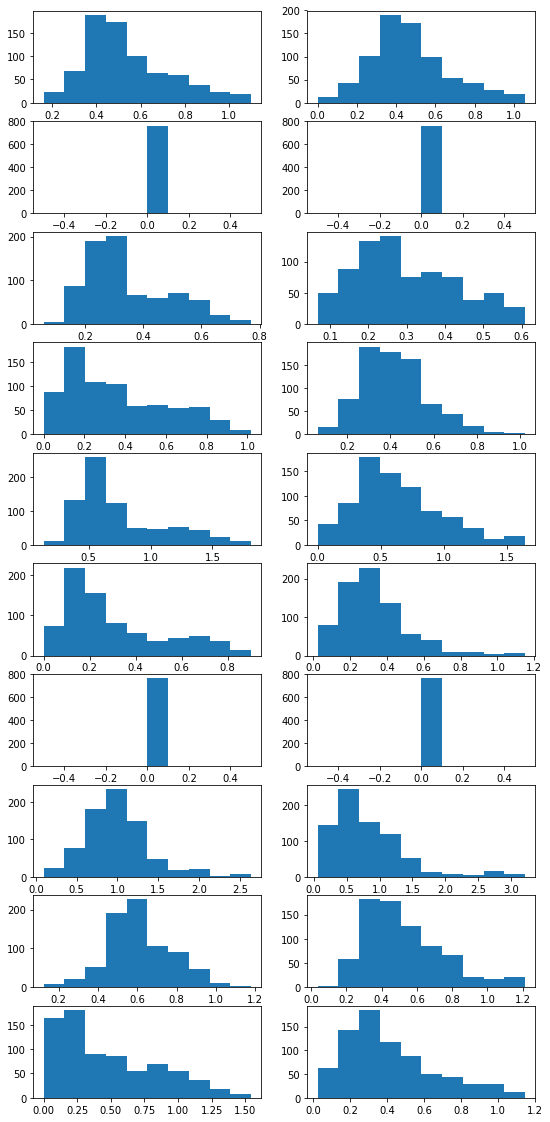

In [39]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx5'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    n_filters = 70
    filter_size = [3, 3]
    strides = [1, 1]
    ae = add_encoder_layer(pred1['z'], n_filters, filter_size, strides)
    
    sess = tf.Session()
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z1 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z2 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    print('z1.shape =', z1.shape)
    print('z2.shape =', z2.shape)

shape = z1.shape
tmp1 = np.reshape(z1, (shape[0]*shape[1]*shape[2], shape[3]))
# plt.hist(tmp1[:, 0])
tmp2 = np.reshape(z2, (shape[0]*shape[1]*shape[2], shape[3]))
fig, axes = plt.subplots(10, 2, figsize=(9, 20))
for idx in range(10):
    axes[idx, 0].hist(tmp1[:, idx])
    axes[idx, 1].hist(tmp2[:, idx])

In [40]:
saved_model = 'modelxxx6'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1_1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae1_2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1_1 = add_predict_layer_with_weight(ae1_1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    pred1_2 = add_predict_layer_with_weight(ae1_2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2_1 = add_encoder_layer_with_weight(pred1_1['z'], weight_file, bias_file, strides)
    ae2_2 = add_encoder_layer_with_weight(pred1_2['z'], weight_file, bias_file, strides)
    
    filter_size = [1, 5]
    strides = [1, 1]
    head_cell_n = 40
    place_cell_n = 30
    pred = add_predict_layer(ae2_1['z'], ae2_2['z'], filter_size, strides, head_cell_n, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w5, b5, w6, b6 = sess.run([pred['w2'], pred['b2'], pred['w3'], pred['b3']])
    print('w5.shape = ', w5.shape, 'b5.shape = ', b5.shape, 'w6.shape = ', w6.shape, 'b6.shape = ', b6.shape)
    np.save('model/w5.npy', w5)
    np.save('model/b5.npy', b5)
    np.save('model/w6.npy', w6)
    np.save('model/b6.npy', b6)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
encode_layer_t1 has shape = (1, 1, 19, 70)
encode_layer_t2 has shape = (1, 1, 19, 70)
head_layer_t1 has shape = (1, 1, 15, 40)
encode_layer_t2_H has shape = (1, 1, 19, 70)
place_layer_t1 has shape = (1, 1, 15, 30)
encode_layer_t2_P has shape = (1, 1, 19, 70)
0 : 0 step =  1.99999999998 angle = 0.0 :1:cost1 = 1226.13 co

In [43]:
saved_model = 'modelxxx7'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2 = add_encoder_layer_with_weight(pred1['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w5.npy'
    H_bias_file = 'b5.npy'
    P_weight_file = 'w6.npy'
    P_bias_file = 'b6.npy'
    strides = [1, 1]
    pred2 = add_predict_layer_with_weight(ae2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    n_filters = 70
    filter_size = [1, 8]
    strides = [1, 1]
    ae = add_encoder_layer(pred2['z'], n_filters, filter_size, strides, 0.5)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 2
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
    
    w7, b7 = sess.run([ae['W'], ae['b']])
    print('w7.shape = ', w7.shape, 'b7.shape = ', b7.shape)
    np.save('model/w7.npy', w7)
    np.save('model/b7.npy', b7)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The head_layer has shape (40, 3, 21, 40)
The place_layer has shape (40, 3, 21, 30)
The layer z has shape (40, 3, 21, 70)
The input layer x has shape (40, 3, 21, 70)
The encoding layer z has shape (40, 1, 19, 70)
The input layer x has shape (40, 1, 19, 70)
The head_layer has shape (40, 1, 15, 40)
The place_layer has shape (40, 1, 15, 30)
The layer z has shape (40, 1, 15, 70)
The input layer x has shape (40, 1, 15, 70)
The encoding layer z has shape (40, 1, 8, 70)
The output layer y has shape (40, 1, 15, 70)
INFO:tensorflow:Restoring parameters from model/modelxxx7
0 :1: 0 :cost = 1095.22 l2_cost = 7.319 cost_t = 1102.54
0 :1: 1000 :cost = 411.177 l2_cost = 7.3636 cost_t = 418.541
0 :1: 2000 :cost = 526.516 l2_cost = 7.23818 cost_t = 533.754
0 :1: 3000 :cost = 415.935 l2_cost = 7.3809 cost_t = 423.316
0 :1: 4000 :cost = 469.563 l2_cost = 7.15674 cost_t =

1 :2: 1000 :cost = 378.748 l2_cost = 7.21989 cost_t = 385.968
1 :2: 2000 :cost = 462.167 l2_cost = 7.23411 cost_t = 469.401
1 :2: 3000 :cost = 452.466 l2_cost = 7.18689 cost_t = 459.653
1 :2: 4000 :cost = 452.927 l2_cost = 7.375 cost_t = 460.302
1 :2: 5000 :cost = 507.259 l2_cost = 7.41128 cost_t = 514.67
1 :2: 6000 :cost = 404.96 l2_cost = 7.17193 cost_t = 412.132
1 :2: 7000 :cost = 430.813 l2_cost = 7.0942 cost_t = 437.907
1 :2: 8000 :cost = 360.487 l2_cost = 7.21026 cost_t = 367.697
1 :2: 9000 :cost = 457.879 l2_cost = 7.14555 cost_t = 465.025
1 :2: 10000 :cost = 499.857 l2_cost = 7.29233 cost_t = 507.149
1 :2: 11000 :cost = 309.605 l2_cost = 7.3261 cost_t = 316.931
1 :2: 12000 :cost = 554.962 l2_cost = 7.27013 cost_t = 562.232
1 :2: 13000 :cost = 539.01 l2_cost = 7.1328 cost_t = 546.142
1 :2: 14000 :cost = 508.533 l2_cost = 7.15257 cost_t = 515.685
1 :2: 15000 :cost = 420.721 l2_cost = 7.40381 cost_t = 428.125
1 :2: 16000 :cost = 636.029 l2_cost = 7.25924 cost_t = 643.288
1 :2: 170

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The head_layer has shape (40, 3, 21, 40)
The place_layer has shape (40, 3, 21, 30)
The layer z has shape (40, 3, 21, 70)
The input layer x has shape (40, 3, 21, 70)
The encoding layer z has shape (40, 1, 19, 70)
The input layer x has shape (40, 1, 19, 70)
The head_layer has shape (40, 1, 15, 40)
The place_layer has shape (40, 1, 15, 30)
The layer z has shape (40, 1, 15, 70)
The input layer x has shape (40, 1, 15, 70)
The encoding layer z has shape (40, 1, 8, 70)
The output layer y has shape (40, 1, 15, 70)
INFO:tensorflow:Restoring parameters from model/modelxxx7
step commands are [ 0.  0.  0.  2.  2.  2.  2.  0.  0.  0.  0.  0.  2.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  2.  0.  0.  0.  2.  0.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
angle commands are [-10. -10. -10.   0.   0.   0.   0. -10. -10. -10. -10. -10.   0.   0. -10.
 -10. -10. -10. -10. 

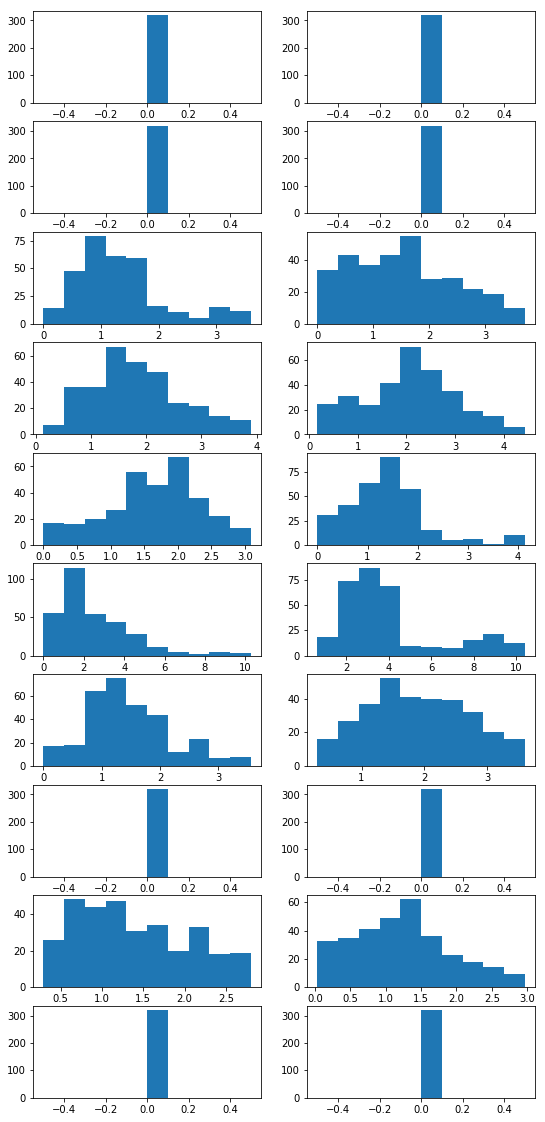

In [44]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx7'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2 = add_encoder_layer_with_weight(pred1['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w5.npy'
    H_bias_file = 'b5.npy'
    P_weight_file = 'w6.npy'
    P_bias_file = 'b6.npy'
    strides = [1, 1]
    pred2 = add_predict_layer_with_weight(ae2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    n_filters = 70
    filter_size = [1, 8]
    strides = [1, 1]
    ae = add_encoder_layer(pred2['z'], n_filters, filter_size, strides, 0.5)
    
    sess = tf.Session()
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z1 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z2 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    print('z1.shape =', z1.shape)
    print('z2.shape =', z2.shape)

shape = z1.shape
tmp1 = np.reshape(z1, (shape[0]*shape[1]*shape[2], shape[3]))
# plt.hist(tmp1[:, 0])
tmp2 = np.reshape(z2, (shape[0]*shape[1]*shape[2], shape[3]))
fig, axes = plt.subplots(10, 2, figsize=(9, 20))
for idx in range(10):
    axes[idx, 0].hist(tmp1[:, idx])
    axes[idx, 1].hist(tmp2[:, idx])

In [ ]:
saved_model = 'modelxxx8'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1_1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae1_2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1_1 = add_predict_layer_with_weight(ae1_1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    pred1_2 = add_predict_layer_with_weight(ae1_2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2_1 = add_encoder_layer_with_weight(pred1_1['z'], weight_file, bias_file, strides)
    ae2_2 = add_encoder_layer_with_weight(pred1_2['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w5.npy'
    H_bias_file = 'b5.npy'
    P_weight_file = 'w6.npy'
    P_bias_file = 'b6.npy'
    strides = [1, 1]
    pred2_1 = add_predict_layer_with_weight(ae2_1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    pred2_2 = add_predict_layer_with_weight(ae2_2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w7.npy'
    bias_file = 'b7.npy'
    strides = [1, 1]
    ae3_1 = add_encoder_layer_with_weight(pred2_1['z'], weight_file, bias_file, strides)
    ae3_2 = add_encoder_layer_with_weight(pred2_2['z'], weight_file, bias_file, strides)
    
    filter_size = [1, 8]
    strides = [1, 1]
    head_cell_n = 40
    place_cell_n = 30
    pred = add_predict_layer(ae3_1['z'], ae3_2['z'], filter_size, strides, head_cell_n, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w8, b8, w9, b9 = sess.run([pred['w2'], pred['b2'], pred['w3'], pred['b3']])
    print('w8.shape = ', w8.shape, 'b8.shape = ', b8.shape, 'w9.shape = ', w9.shape, 'b9.shape = ', b9.shape)
    np.save('model/w8.npy', w8)
    np.save('model/b8.npy', b8)
    np.save('model/w9.npy', w9)
    np.save('model/b9.npy', b9)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
The input layer x has shape (1, 1, 19, 70)
The head_layer has shape (1, 1, 15, 40)
The place_layer has shape (1, 1, 15, 30)
The layer z has shape (1, 1, 15, 70)
The input layer x has shape (1, 1, 19, 70)
The head_layer has shape (1, 1, 15, 40)
The place_layer has shape (1, 1, 15, 30)
The layer z has shape (1, 1, 15, 70

# Head and Place Cells Test

In [46]:
# load test data
test_images = np.load('test_images.npy')
print(test_images.shape)
# test_mean_img = np.mean(test_images, axis=0)
# print('test_mean_img.shape =', test_mean_img.shape)
# plt.imshow(test_mean_img[:, :, 0], cmap='gray')

test_cmds = np.load('test_cmds.npy')
print(test_cmds.shape)
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
print(test_xs.shape, len(test_x_set))
# print(test_x_set)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
print(test_ys.shape, len(test_y_set))
# print(test_y_set)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
print(test_angles.shape, len(test_angle_set))
# print(test_angle_set)

(12096, 40, 320, 1)
(12096, 3)
(12096,) 24
(12096,) 14
(12096,) 36


In [ ]:
head_map_4_head_cell = np.zeros((36, 40))
place_map_4_head_cell = np.zeros((14, 24, 40))
head_map_4_place_cell = np.zeros((36, 30))
place_map_4_place_cell = np.zeros((14, 24, 30))

saved_model = 'modelxxx8'
example_num = 1
batch_size = example_num

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2 = add_encoder_layer_with_weight(pred1['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w5.npy'
    H_bias_file = 'b5.npy'
    P_weight_file = 'w6.npy'
    P_bias_file = 'b6.npy'
    strides = [1, 1]
    pred2 = add_predict_layer_with_weight(ae2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w7.npy'
    bias_file = 'b7.npy'
    strides = [1, 1]
    ae3 = add_encoder_layer_with_weight(pred2['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w8.npy'
    H_bias_file = 'b8.npy'
    P_weight_file = 'w9.npy'
    P_bias_file = 'b9.npy'
    strides = [1, 1]
    pred = add_predict_layer_with_weight(ae3['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    sess = tf.Session()
    # load the trained weights
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)
    
    for idx in range(test_images.shape[0]):
        batch_xs = test_images[(idx*batch_size):((idx+1)*batch_size), :, :, :]
    #     test_image = np.array([img - test_mean_img for img in batch_xs])
        test_image = batch_xs
        test_x = test_xs[(idx*batch_size):((idx+1)*batch_size)]
        test_y = test_ys[(idx*batch_size):((idx+1)*batch_size)]
        test_angle = test_angles[(idx*batch_size):((idx+1)*batch_size)]
        Head_val, Place_val = sess.run([pred['z1'], pred['z2']], feed_dict={x: test_image})
        print(idx, 'Head_val.shape =', Head_val.shape, 'Place_val.shape =', Place_val.shape)
        for idx2 in range(batch_size):
            head_map_4_head_cell[test_angle[idx2].astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            place_map_4_head_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            head_map_4_place_cell[test_angle[idx2].astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]
            place_map_4_place_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
The input layer x has shape (1, 1, 19, 70)
The head_layer has shape (1, 1, 15, 40)
The place_layer has shape (1, 1, 15, 30)
The layer z has shape (1, 1, 15, 70)
The input layer x has shape (1, 1, 15, 70)
The encoding layer z has shape (1, 1, 8, 70)
The input layer x has shape (1, 1, 8, 70)
The head_layer has shape (1, 1, 1, 40)
The place_layer has shape (1, 1, 1, 30)
The layer z has shape (1, 1, 1, 70)
0 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1

125 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
126 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
127 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
128 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
129 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
130 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
131 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
132 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
133 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
134 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
135 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
136 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
137 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
138 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
139 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

273 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
274 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
275 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
276 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
277 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
278 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
279 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
280 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
281 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
282 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
283 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
284 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
285 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
286 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
287 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

409 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
410 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
411 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
412 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
413 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
414 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
415 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
416 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
417 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
418 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
419 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
420 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
421 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
422 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
423 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

567 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
568 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
569 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
570 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
571 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
572 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
573 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
574 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
575 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
576 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
577 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
578 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
579 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
580 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
581 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

723 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
724 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
725 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
726 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
727 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
728 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
729 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
730 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
731 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
732 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
733 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
734 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
735 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
736 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
737 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

847 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
848 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
849 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
850 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
851 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
852 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
853 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
854 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
855 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
856 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
857 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
858 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
859 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
860 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
861 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

988 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
989 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
990 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
991 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
992 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
993 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
994 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
995 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
996 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
997 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
998 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
999 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1000 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1001 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1002 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1,

1137 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1138 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1139 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1140 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1141 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1142 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1143 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1144 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1145 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1146 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1147 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1148 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1149 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1150 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1151 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1258 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1259 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1260 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1261 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1262 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1263 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1264 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1265 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1266 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1267 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1268 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1269 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1270 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1271 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1272 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1383 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1384 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1385 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1386 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1387 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1388 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1389 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1390 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1391 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1392 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1393 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1394 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1395 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1396 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1397 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1505 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1506 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1507 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1508 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1509 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1510 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1511 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1512 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1513 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1514 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1515 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1516 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1517 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1518 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1519 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1651 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1652 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1653 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1654 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1655 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1656 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1657 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1658 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1659 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1660 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1661 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1662 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1663 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1664 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1665 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1774 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1775 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1776 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1777 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1778 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1779 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1780 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1781 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1782 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1783 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1784 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1785 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1786 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1787 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1788 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1898 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1899 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1900 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1901 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1902 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1903 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1904 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1905 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1906 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1907 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1908 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1909 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1910 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1911 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1912 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2022 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2023 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2024 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2025 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2026 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2027 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2028 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2029 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2030 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2031 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2032 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2033 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2034 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2035 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2036 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2160 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2161 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2162 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2163 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2164 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2165 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2166 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2167 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2168 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2169 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2170 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2171 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2172 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2173 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2174 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2293 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2294 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2295 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2296 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2297 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2298 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2299 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2300 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2301 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2302 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2303 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2304 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2305 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2306 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2307 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2427 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2428 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2429 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2430 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2431 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2432 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2433 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2434 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2435 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2436 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2437 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2438 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2439 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2440 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2441 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2552 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2553 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2554 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2555 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2556 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2557 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2558 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2559 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2560 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2561 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2562 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2563 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2564 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2565 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2566 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2681 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2682 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2683 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2684 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2685 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2686 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2687 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2688 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2689 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2690 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2691 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2692 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2693 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2694 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2695 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2818 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2819 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2820 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2821 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2822 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2823 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2824 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2825 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2826 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2827 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2828 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2829 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2830 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2831 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2832 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2941 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2942 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2943 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2944 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2945 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2946 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2947 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2948 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2949 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2950 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2951 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2952 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2953 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2954 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2955 Head_val.shape = (1, 1, 1, 40) Place_val.sh

In [ ]:
fig, axs = plt.subplots(40, 2, figsize=(18, 90))
for example_i in range(40):
    axs[example_i][0].plot(np.abs(head_map_4_head_cell[:, example_i]))
    min_val = min(head_map_4_head_cell[:, example_i])
    max_val = max(head_map_4_head_cell[:, example_i])
    axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[example_i][1].imshow(np.abs(place_map_4_head_cell[:, 0:23, example_i]))
plt.show()

In [ ]:
fig, axs = plt.subplots(30, 2, figsize=(18, 72))
for example_i in range(30):
    axs[example_i][0].plot(np.abs(head_map_4_place_cell[:, example_i]))
    min_val = min(head_map_4_head_cell[:, example_i])
    max_val = max(head_map_4_head_cell[:, example_i])
    axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[example_i][1].imshow(np.abs(place_map_4_place_cell[:, 0:23, example_i]))
plt.show()